In [457]:
%pip install -q -r requirements-ml.txt
%pip install lightgbm
%pip install optuna

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import lightgbm as lgbm
import numpy as np
import sklearn
import pandas as pd
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
import optuna
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Определение стоимости автомобилей

In [3]:
##Загружаем данные и проводим первичную оценку.
#df = pd.read_csv('autos.csv')
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df['PostalCode'] = df['PostalCode']//1000

In [6]:
pd.to_datetime(df['LastSeen'], format="%Y-%m-%d %H:%M:%S")
df['LastSeen_Year'] = pd.DatetimeIndex(df['LastSeen']).year
df['Age'] = pd.DatetimeIndex(df['LastSeen']) - pd.DatetimeIndex(df['DateCreated'] )#.astype('int')

df['Age'] = pd.DatetimeIndex(df['Age']).astype('datetime64[ns]').day
df['Age']

0         15
1         15
2         23
3          1
4          7
          ..
354364     1
354365    24
354366     7
354367    20
354368     5
Name: Age, Length: 354369, dtype: int64

In [7]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,LastSeen_Year,Age
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369,354369.0,354369.000000
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150,NaN,NaN
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54,NaN,NaN
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17,NaN,NaN
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50.061964,NaN,2016.0,9.211079
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25.795614,NaN,0.0,7.942363
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,2016.0,1.000000
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30.000000,NaN,2016.0,3.000000
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49.000000,NaN,2016.0,7.000000
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71.000000,NaN,2016.0,14.000000


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 18 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
LastSeen_Year        354369 non-null int64
Age                  354369 non-null int64
dtypes: int64(9), object(9)
memory usage: 48.7+ MB


In [9]:
def fillna(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col
df=df.apply(lambda col:fillna(col))

In [10]:
numeric = ['RegistrationYear', 'Power', 'Price']
low = .01
high = .99
#filt_df = df[numeric]
quant_df = df[numeric].quantile([low, high])
df[numeric] = df[numeric].apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 18 columns):
DateCrawled          354369 non-null object
Price                340040 non-null float64
VehicleType          354369 non-null object
RegistrationYear     346240 non-null float64
Gearbox              354369 non-null object
Power                310425 non-null float64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
LastSeen_Year        354369 non-null int64
Age                  354369 non-null int64
dtypes: float64(3), int64(6), object(9)
memory usage: 48.7+ MB


In [11]:
df.dropna(inplace=True)

In [12]:
#df['car_age'] =[]
def age(row):
    if (row['RegistrationYear']>=1981) & (row['RegistrationYear']<1991):
        car_age = 'Super_retro'
        
    if (row['RegistrationYear']>=1991) & (row['RegistrationYear']<2001):
        car_age = 'retro' 
        
    if (row['RegistrationYear']>=2001) & (row['RegistrationYear']<2011):
        car_age = 'Super_old'
       
    if (row['RegistrationYear']>=2011) & (row['RegistrationYear']<2015):
        car_age =  'old'
        
    else:
        car_age =  'new'
    return(car_age)
    #df['car_age'].append(row['car_age'])

In [13]:
df['car_age'] = df.apply(age, axis=1)

In [15]:
df_ohe = pd.get_dummies(df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1), drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,LastSeen_Year,Age,VehicleType_convertible,VehicleType_coupe,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes,car_age_old
1,18300.0,2011.0,190.0,125000,5,66,2016,15,0,1,...,0,0,0,0,0,0,0,0,1,1
2,9800.0,2004.0,163.0,125000,8,90,2016,23,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500.0,2001.0,75.0,150000,6,91,2016,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600.0,2008.0,69.0,90000,7,60,2016,7,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650.0,1995.0,102.0,150000,10,33,2016,3,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295313 entries, 1 to 354368
Data columns (total 19 columns):
DateCrawled          295313 non-null object
Price                295313 non-null float64
VehicleType          295313 non-null object
RegistrationYear     295313 non-null float64
Gearbox              295313 non-null object
Power                295313 non-null float64
Model                295313 non-null object
Kilometer            295313 non-null int64
RegistrationMonth    295313 non-null int64
FuelType             295313 non-null object
Brand                295313 non-null object
NotRepaired          295313 non-null object
DateCreated          295313 non-null object
NumberOfPictures     295313 non-null int64
PostalCode           295313 non-null int64
LastSeen             295313 non-null object
LastSeen_Year        295313 non-null int64
Age                  295313 non-null int64
car_age              295313 non-null object
dtypes: float64(3), int64(6), object(10)
memory usage: 4

In [17]:
df_enc = df
enc = OrdinalEncoder()
df_enc[['VehicleType', 'Gearbox', 'Model',
    'FuelType', 'Brand', 'NotRepaired', 'PostalCode', 'car_age']] = enc.fit_transform(df_enc[['VehicleType', 'Gearbox', 'Model',
    'FuelType', 'Brand', 'NotRepaired', 'PostalCode', 'car_age']])
df_enc = df_enc.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1)

In [18]:
X = df_ohe.drop(['Price'], axis=1)
y = df_ohe['Price']
X.shape, y.shape

((295313, 309), (295313,))

In [19]:
X_enc = df_enc.drop(['Price'], axis=1)
y_enc = df_enc['Price']
X_enc.shape, y_enc.shape

((295313, 14), (295313,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [21]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.25, random_state=12345)

## Обучение моделей

In [22]:
def cv_score(model):
    #%%time
    m = model
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=12345)
    n_scores = [math.sqrt(-i) for i in cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=cv,
                                                       n_jobs=-1, error_score='raise')]
    print('RMSE: %.3f (std: %.3f)' % (mean(n_scores), std(n_scores)))
    
    

In [23]:
def score_ohe(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return (mean_squared_error(y_test, pred)**0.5)

In [24]:
def score_enc(model):
    model.fit(X_train_enc, y_train_enc)
    pred = model.predict(X_test_enc)
    return (mean_squared_error(y_test_enc, pred)**0.5)

In [25]:
%%time
model = DecisionTreeRegressor(random_state=12345)
score_ohe(model)

CPU times: user 7.57 s, sys: 239 ms, total: 7.81 s
Wall time: 7.92 s


1923.3083111164703

In [26]:
%%time
model = DecisionTreeRegressor(random_state=12345)
score_enc(model)

CPU times: user 1.47 s, sys: 15.9 ms, total: 1.49 s
Wall time: 1.49 s


1975.0392869400434

In [27]:
%%time
model = LinearRegression()
score_ohe(model)

CPU times: user 13.7 s, sys: 3.84 s, total: 17.5 s
Wall time: 17.5 s


2280.81734034233

In [28]:
%%time
model = LinearRegression()
score_enc(model)

CPU times: user 170 ms, sys: 76.3 ms, total: 246 ms
Wall time: 168 ms


2566.725513250951

In [29]:
%%time
model = RandomForestRegressor(random_state=12345, criterion= 'mse', n_estimators=10, n_jobs=-1)
score_ohe(model)

CPU times: user 48.6 s, sys: 182 ms, total: 48.8 s
Wall time: 49.6 s


1487.36102083293

In [30]:
%%time
model = RandomForestRegressor(random_state=12345, criterion= 'mse', n_estimators=10, n_jobs=-1)
score_enc(model)

CPU times: user 9.6 s, sys: 69.2 ms, total: 9.67 s
Wall time: 9.7 s


1505.1459774562184

In [31]:
%%time
model = RandomForestRegressor(random_state=12345, criterion= 'mse', n_estimators=100, n_jobs=-1)
score_enc(model)

CPU times: user 1min 34s, sys: 929 ms, total: 1min 35s
Wall time: 1min 36s


1440.9601710016825

## XGBoost

In [33]:
def score_(model, X_train, X_test, y_train, y_test, early_stopping_rounds, metric):  
    eval_set = [(X_test, y_test)]

    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        early_stopping_rounds=early_stopping_rounds,
        eval_metric=metric)
    preds = model.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.mean_squared_error(y_test, pred_labels)
    return (accuracy**0.5)

In [531]:
%%time
model = xgb.XGBRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
score_(model, X_train, X_test, y_train, y_test, 100, 'rmse')

[19:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5729.46
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5286
[2]	validation_0-rmse:4892.79
[3]	validation_0-rmse:4543.66
[4]	validation_0-rmse:4236.73
[5]	validation_0-rmse:3958.2
[6]	validation_0-rmse:3716.54
[7]	validation_0-rmse:3506.74
[8]	validation_0-rmse:3321.34
[9]	validation_0-rmse:3157.72
[10]	validation_0-rmse:3009.22
[11]	validation_0-rmse:2886.96
[12]	validation_0-rmse:2775.07
[13]	validation_0-rmse:2680.57
[14]	validation_0-rmse:2602.14
[15]	validation_0-rmse:2528.16
[16]	validation_0-rmse:2459.51
[17]	validation_0-rmse:2397.89
[18]	validation_0-rmse:2347.26
[19]	validation_0-rmse:2300
[20]	validation_0-rmse:2261.9
[21]	validation_0-rmse:2230.03
[22]	validation_0-rmse:2201.23
[23]	validation_0-rmse:2173.38
[24]	validation_0-rmse:2151.3
[25]	validation_0-rmse:2129.66
[26]	validation_0-rm

1762.1336064856578

In [34]:
%%time
model = xgb.XGBRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
score_(model, X_train_enc, X_test_enc, y_train_enc, y_test_enc, 100, 'rmse')

[05:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5729.5
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5286.03
[2]	validation_0-rmse:4892.93
[3]	validation_0-rmse:4543.79
[4]	validation_0-rmse:4236.71
[5]	validation_0-rmse:3958.2
[6]	validation_0-rmse:3716.6
[7]	validation_0-rmse:3507.67
[8]	validation_0-rmse:3322.36
[9]	validation_0-rmse:3159.28
[10]	validation_0-rmse:3010.64
[11]	validation_0-rmse:2888.82
[12]	validation_0-rmse:2777.61
[13]	validation_0-rmse:2682.99
[14]	validation_0-rmse:2604.07
[15]	validation_0-rmse:2530.35
[16]	validation_0-rmse:2459.03
[17]	validation_0-rmse:2399.95
[18]	validation_0-rmse:2348.66
[19]	validation_0-rmse:2305.42
[20]	validation_0-rmse:2265.85
[21]	validation_0-rmse:2231.09
[22]	validation_0-rmse:2202
[23]	validation_0-rmse:2177.34
[24]	validation_0-rmse:2154.75
[25]	validation_0-rmse:2135.73
[26]	validation_0

1764.9970654735318

Качество предсказания получилось одинаковое, зато датасет с encoding обучается быстрее.

## LGBM

In [533]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
score_(model, X_train, X_test, y_train, y_test, 100, 'rmse')

[1]	valid_0's rmse: 3957.15	valid_0's l2: 1.56591e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 3687.81	valid_0's l2: 1.35999e+07
[3]	valid_0's rmse: 3450.07	valid_0's l2: 1.1903e+07
[4]	valid_0's rmse: 3240	valid_0's l2: 1.04976e+07
[5]	valid_0's rmse: 3057.35	valid_0's l2: 9.34738e+06
[6]	valid_0's rmse: 2898.61	valid_0's l2: 8.40196e+06
[7]	valid_0's rmse: 2758.49	valid_0's l2: 7.60925e+06
[8]	valid_0's rmse: 2636.97	valid_0's l2: 6.95363e+06
[9]	valid_0's rmse: 2532.36	valid_0's l2: 6.41283e+06
[10]	valid_0's rmse: 2436.6	valid_0's l2: 5.93703e+06
[11]	valid_0's rmse: 2353.8	valid_0's l2: 5.54035e+06
[12]	valid_0's rmse: 2281.73	valid_0's l2: 5.20629e+06
[13]	valid_0's rmse: 2216.82	valid_0's l2: 4.9143e+06
[14]	valid_0's rmse: 2158.81	valid_0's l2: 4.66045e+06
[15]	valid_0's rmse: 2109.35	valid_0's l2: 4.44935e+06
[16]	valid_0's rmse: 2064.14	valid_0's l2: 4.26068e+06
[17]	valid_0's rmse: 2024.78	valid_0's l2: 4.09972e+06
[18]	valid_0's rmse

1533.8670620586126

In [35]:
def eval(model, params):
    grid = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)                                                   
    accuracy = sklearn.metrics.mean_squared_error(y_test, pred)
    accuracy**0.5
    print('RMSE', (accuracy**0.5))
    print(grid.best_params_)

In [36]:
def eval_enc(model, params):
    grid = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_enc, y_train_enc)
    pred = grid.predict(X_test_enc)                                                   
    accuracy = sklearn.metrics.mean_squared_error(y_test_enc, pred)
    accuracy**0.5
    print('RMSE', (accuracy**0.5))
    print(grid.best_params_)

### Настройка гиперпараметров LGBM

In [37]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
eval(model, {'max_depth':[3, 5, 10, None]})

RMSE 1533.8670581773122
{'max_depth': None}
CPU times: user 1min 21s, sys: 4 s, total: 1min 25s
Wall time: 1min 26s


In [537]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
eval(model, {'learning_rate':np.arange(0.1, 1, 0.2)})

RMSE 1482.5985127825068
{'learning_rate': 0.30000000000000004}
CPU times: user 5.29 s, sys: 724 ms, total: 6.01 s
Wall time: 21.1 s


In [538]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.3, n_jobs=-1)
eval(model, {'reg_lambda':np.arange(0, 10, 2)})

RMSE 1482.5985127825068
{'reg_lambda': 0}
CPU times: user 5.26 s, sys: 760 ms, total: 6.02 s
Wall time: 22 s


In [539]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.3, n_jobs=-1, reg_lambda=2)
eval(model, {'num_leaves':np.arange(20, 100, 10)})

RMSE 1439.9481197197763
{'num_leaves': 80}
CPU times: user 6.6 s, sys: 764 ms, total: 7.36 s
Wall time: 33.9 s


In [540]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.3, n_jobs=-1, num_leaves=90, reg_lambda=2, n_estimators=100)
eval(model, {'reg_alpha':np.arange(0, 20, 2)})

RMSE 1438.4968886567342
{'reg_alpha': 12}
CPU times: user 6.92 s, sys: 784 ms, total: 7.7 s
Wall time: 46 s


In [541]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.3, n_jobs=-1, num_leaves=90, reg_lambda=2, reg_alpha=18)
eval(model, {'n_estimators':[100,300]})

RMSE 1415.4358725854431
{'n_estimators': 300}
CPU times: user 13.1 s, sys: 860 ms, total: 13.9 s
Wall time: 17.1 s


In [542]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.3, n_jobs=-1, num_leaves=90, reg_lambda=2, reg_alpha=18, n_estimators=300)
score_(model, X_train, X_test, y_train, y_test, 50, "root_mean_squared_error")

[1]	valid_0's rmse: 3313.92	valid_0's l2: 1.0982e+07
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 2710.28	valid_0's l2: 7.3456e+06
[3]	valid_0's rmse: 2321.1	valid_0's l2: 5.38752e+06
[4]	valid_0's rmse: 2076.8	valid_0's l2: 4.31311e+06
[5]	valid_0's rmse: 1915.81	valid_0's l2: 3.67033e+06
[6]	valid_0's rmse: 1814.94	valid_0's l2: 3.29402e+06
[7]	valid_0's rmse: 1738.47	valid_0's l2: 3.02227e+06
[8]	valid_0's rmse: 1687.2	valid_0's l2: 2.84663e+06
[9]	valid_0's rmse: 1651.02	valid_0's l2: 2.72586e+06
[10]	valid_0's rmse: 1621.09	valid_0's l2: 2.62794e+06
[11]	valid_0's rmse: 1601.39	valid_0's l2: 2.56446e+06
[12]	valid_0's rmse: 1586.69	valid_0's l2: 2.5176e+06
[13]	valid_0's rmse: 1575.1	valid_0's l2: 2.48093e+06
[14]	valid_0's rmse: 1565.7	valid_0's l2: 2.45141e+06
[15]	valid_0's rmse: 1554.11	valid_0's l2: 2.41527e+06
[16]	valid_0's rmse: 1544.28	valid_0's l2: 2.38479e+06
[17]	valid_0's rmse: 1537.36	valid_0's l2: 2.36349e+06
[18]	valid_0's rmse: 

1415.286937264769

In [543]:
%%time
model.predict(X_test)

CPU times: user 2.25 s, sys: 156 ms, total: 2.4 s
Wall time: 847 ms


array([ 5001.94111718,  5045.79944061,  1184.60815004, ...,
       13087.86610685,  6387.19307724,  1931.25398373])

### То же самое с encoding датасетом:

In [544]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
eval_enc(model, {'max_depth':[3, 5, 10, None]})

RMSE 1549.0119514551893
{'max_depth': None}
CPU times: user 5.1 s, sys: 64 ms, total: 5.16 s
Wall time: 9.68 s


In [545]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
eval_enc(model, {'learning_rate':np.arange(0.01, 1, 0.2)})

RMSE 1482.0733049495323
{'learning_rate': 0.41000000000000003}
CPU times: user 3.42 s, sys: 76 ms, total: 3.5 s
Wall time: 10.3 s


In [546]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.41, n_jobs=-1)
eval_enc(model, {'num_leaves':np.arange(2, 100, 20)})

RMSE 1460.2638255667252
{'num_leaves': 82}
CPU times: user 4.2 s, sys: 84 ms, total: 4.28 s
Wall time: 9.34 s


In [547]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.41, n_jobs=-1, num_leaves=62)
eval_enc(model, {'reg_lambda':np.arange(0, 10, 2)})

RMSE 1455.6787370904483
{'reg_lambda': 6}
CPU times: user 4.08 s, sys: 76 ms, total: 4.16 s
Wall time: 10.5 s


In [548]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.41, n_jobs=-1, num_leaves=62, reg_lambda=8)
eval_enc(model, {'n_estimators':[100,300]})

RMSE 1442.7001537643073
{'n_estimators': 300}
CPU times: user 9.56 s, sys: 104 ms, total: 9.67 s
Wall time: 9.73 s


In [549]:
%%time
model = LGBMRegressor(n_estimators=300, random_state=12345, learning_rate=0.41, n_jobs=-1, num_leaves=62, reg_lambda=8)
eval_enc(model, {'reg_alpha':np.arange(0, 10, 2)})

RMSE 1442.7001537643073
{'reg_alpha': 0}
CPU times: user 9.66 s, sys: 120 ms, total: 9.78 s
Wall time: 24.5 s


In [550]:
%%time
model = LGBMRegressor(n_estimators=300, random_state=12345, learning_rate=0.41, n_jobs=-1, num_leaves=62, reg_lambda=8)
eval(model, {'min_child_samples':np.arange(2, 60, 20)})

RMSE 1420.2928072680832
{'min_child_samples': 2}
CPU times: user 11.2 s, sys: 788 ms, total: 12 s
Wall time: 26.7 s


In [551]:
%%time
model = LGBMRegressor(n_estimators=300, random_state=12345, learning_rate=0.41, n_jobs=-1, num_leaves=62, reg_lambda=8, min_child_samples=2)
score_(model, X_train_enc, X_test_enc, y_train_enc, y_test_enc, 50, "root_mean_squared_error")

[1]	valid_0's rmse: 3031.4	valid_0's l2: 9.18941e+06
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 2408.66	valid_0's l2: 5.80162e+06
[3]	valid_0's rmse: 2094.2	valid_0's l2: 4.38568e+06
[4]	valid_0's rmse: 1916.19	valid_0's l2: 3.67177e+06
[5]	valid_0's rmse: 1814.75	valid_0's l2: 3.2933e+06
[6]	valid_0's rmse: 1741.93	valid_0's l2: 3.0343e+06
[7]	valid_0's rmse: 1703.42	valid_0's l2: 2.90165e+06
[8]	valid_0's rmse: 1674.3	valid_0's l2: 2.80328e+06
[9]	valid_0's rmse: 1650.47	valid_0's l2: 2.72406e+06
[10]	valid_0's rmse: 1641.49	valid_0's l2: 2.6945e+06
[11]	valid_0's rmse: 1627.91	valid_0's l2: 2.65008e+06
[12]	valid_0's rmse: 1617.78	valid_0's l2: 2.61723e+06
[13]	valid_0's rmse: 1608.35	valid_0's l2: 2.58677e+06
[14]	valid_0's rmse: 1599.08	valid_0's l2: 2.55705e+06
[15]	valid_0's rmse: 1590.73	valid_0's l2: 2.53043e+06
[16]	valid_0's rmse: 1577.07	valid_0's l2: 2.48715e+06
[17]	valid_0's rmse: 1571.43	valid_0's l2: 2.46938e+06
[18]	valid_0's rmse

1431.9241664531037

###  Определяем важность признаков

In [610]:
feature_names = X_train_enc.columns
forest = RandomForestRegressor(random_state=12345, criterion= 'mse', n_estimators=10, n_jobs=-1)
forest.fit(X_train_enc, y_train_enc)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

In [611]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.141 seconds


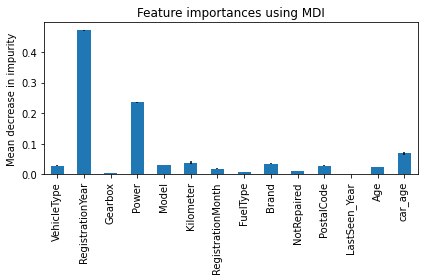

In [612]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Градиентный бустинг с LGBM без категоризации и чистки:

In [38]:
df = pd.read_csv('autos.csv')
X_ = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'Price'], axis=1)
y_ = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.25, random_state=12345)

## Анализ моделей

#### Вывод:
Слабые модели, такие как Линейная регрессия или дерево решений не могут адекватно произвести предсказание. Случайный лес дает плохое качество и обучается слишком долго. XGBoost и LGBM дают приемлемое качество, но LGBM обучается быстрей (предсказывает также быстро). С помощью настройки гиперпараметров удалось достичь метрики RMSE 1694.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей